<a href="https://colab.research.google.com/github/benson85560/yuanta/blob/main/NEW_Div_yld_ATC_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Preparation**

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
from pandas.core.tools.datetimes import to_datetime
import math as m

path = os.getcwd()
print(path)

/content


In [4]:
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
#Colab安裝Talib
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

--2022-08-11 08:29:47--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-08-11 08:29:47--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://cfhcable.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-08-11 08:29:47--  http://cfhcable.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving cfhcable.dl.s

In [8]:
import talib 
from talib import abstract

In [218]:
symbol = '0056.TW'

Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['Date']))
Yield = Yield.drop('Date', axis = 1)

List = []
for i in range(len(Yield)):
  if Yield[symbol][i] > 0:
    List.append(Yield.index[i])

List

[Timestamp('2011-10-26 00:00:00'),
 Timestamp('2012-10-24 00:00:00'),
 Timestamp('2013-10-24 00:00:00'),
 Timestamp('2014-10-24 00:00:00'),
 Timestamp('2015-10-26 00:00:00'),
 Timestamp('2016-10-26 00:00:00'),
 Timestamp('2017-10-30 00:00:00'),
 Timestamp('2018-10-23 00:00:00'),
 Timestamp('2019-10-23 00:00:00'),
 Timestamp('2020-10-28 00:00:00'),
 Timestamp('2021-10-22 00:00:00')]

In [60]:
df['2011-10-24':'2011-10-26']

,open,high,low,close,volume,SAR,pct_30,rolling,0050.TW,0051.TW,...,00701.TW,00712.TW,00713.TW,00714.TW,00717.TW,00728.TW,00730.TW,00731.TW,00733.TW,00735.TW
Date,,,,,,,,,,,,,,,,,,,,,
2011-10-24,25.200001,25.299999,25.000000,25.139999,3100,24.244620,0.003593,0.207845,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-10-25,25.219999,25.230000,25.100000,25.209999,5825,24.377266,0.003583,0.185077,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-10-26,22.930000,23.000000,22.719999,23.000000,1725,25.350000,-0.064280,0.518727,3.6381,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **pct_change strategy**

### for single model

In [68]:
symbol = '0051.TW'
print(f'---loading: {symbol}---')
data = yf.Ticker(symbol)
df = data.history(period='D', start='2009-10-26', end='2021-10-30')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['SAR'] = abstract.SAR(df)
df['pct_30'] = df['close'].pct_change(30)
df['rolling'] = df['close'].rolling(10, win_type ='triang').std()
# df['pct_1'] = df['close'].pct_change(1)

Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['Date']))
Yield = Yield.drop('Date', axis = 1)
df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)

fund = 100 #初始有100元本金
money = 100 #每次投入100元
feeRate = 0.003

first = 0 ##除了第一筆之外，只紀錄出場的時間點
BS = None ##紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0

#--------# 記錄買入、賣出時間點
buy = []
sell_win = []
sell_lose = []
#--------# 
timeList = [] 
profit_list = [0]
profit_fee_list = [0]


for i in range(len(df)):

    if first == 0:
        timeList.append(df.index[i+1])
        first = 1
        continue

    if i == len(df)-1: # last trading day
        break
     
      # buy                      # BS: position, B: buy, S: sell
    if df[symbol][i] > 0 and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 3  and BS == None:
        temp = df['close'][i+1] 
        tempSize = money / temp
        BS = 'B' 
        buy.append(i+1)
        stopLoss = df['SAR'][i+1] * 0.9
        stopEarn = df['close'][i+1] + (abs((df['close'][i+1] - df['SAR'][i+1])) * 1.1)
        continue
        
      # 停利
    if df['close'][i] > stopEarn and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) 
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_win.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

      # 停損
    if df['close'][i] < stopLoss and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) 
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_lose.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue
    
# equity = pd.DataFrame({'profit':profit_list}, index=timeList)
equity = pd.DataFrame({'profit':np.cumsum(profit_list)}, index=timeList)
equity

---loading: 0051.TW---


,profit
2009-10-27,0.000000
2010-12-02,4.542397
2016-01-07,-0.641891


buy:DatetimeIndex(['2010-11-24', '2015-11-25'], dtype='datetime64[ns]', name='Date', freq=None)
win:DatetimeIndex(['2010-12-03'], dtype='datetime64[ns]', name='Date', freq=None)
lose:DatetimeIndex(['2016-01-08'], dtype='datetime64[ns]', name='Date', freq=None)
--------------
win ratio :0.5


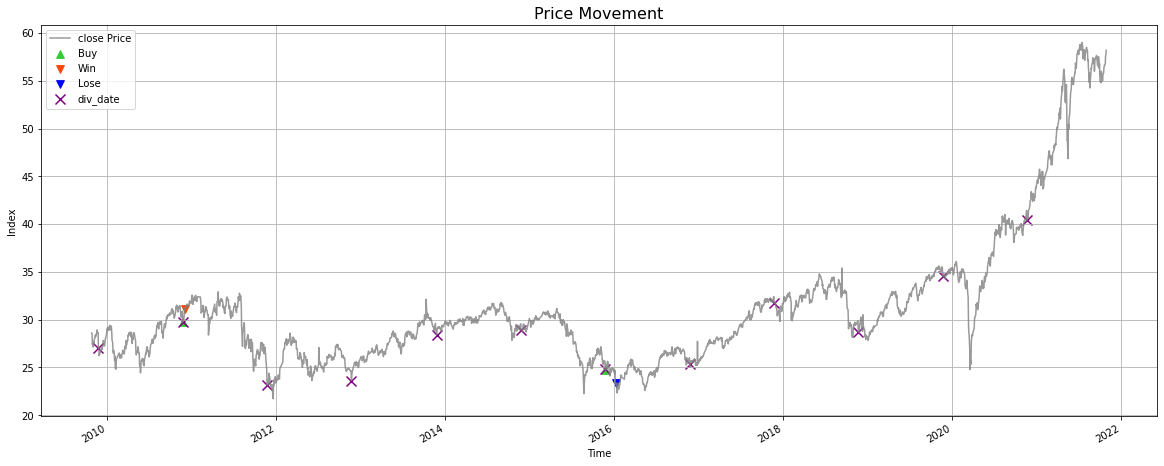

In [69]:
# 實際交易位置
List = []
for i in range(len(df)):
  if df[symbol][i] > 0:
    List.append(df.index[i])

print('buy:{}'.format(df.iloc[buy].index))
print('win:{}'.format(df.iloc[sell_win].index))
print('lose:{}'.format(df.iloc[sell_lose].index))
print('--------------')
print('win ratio :{}'.format(len(sell_win)/len(buy)))

fig, ax = plt.subplots(figsize = (20,8))
df['close'].plot(label = 'close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'limegreen', label = 'Buy', marker='^', s=60)
plt.scatter(df['close'].iloc[sell_win].index, df['close'].iloc[sell_win],c = 'orangered', label = 'Win', marker='v', s=60)
plt.scatter(df['close'].iloc[sell_lose].index, df['close'].iloc[sell_lose],c = 'b', label = 'Lose', marker='v', s=60)
plt.scatter(df['close'].loc[List].index, df['close'].loc[List],c = 'purple', label = 'div_date', marker='x', s=100)

# plt.xlim('2019-09-01', '2020-09-01')
# plt.ylim(25, 30)

plt.legend()
plt.ylabel('Index')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

### for all

In [74]:
symbol = '0050.TW'
print(f'---loading: {symbol}---')
data = yf.Ticker(symbol)
df = data.history(period='D', start='2009-10-26', end='2021-10-30')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['SAR'] = abstract.SAR(df)
df['pct_30'] = df['close'].pct_change(30)
df['rolling'] = df['close'].rolling(10, win_type ='triang').std()
# df['pct_1'] = df['close'].pct_change(1)

Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['Date']))
Yield = Yield.drop('Date', axis = 1)
df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)

fund = 100 #初始有100元本金
money = 100 #每次投入100元
feeRate = 0.003

first = 0 ##除了第一筆之外，只紀錄出場的時間點
BS = None ##紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0

#--------# 記錄買入、賣出時間點
buy = []
sell_win = []
sell_lose = []
#--------# 
timeList = [] 
profit_list = [0]
profit_fee_list = [0]


for i in range(len(df)):

    if first == 0:
        timeList.append(df.index[i+1])
        first = 1
        continue

    if i == len(df)-1: # last trading day
        break
     
      # buy                      # BS: position, B: buy, S: sell
    if df[symbol][i] > 0 and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 3  and BS == None:
        temp = df['close'][i+1] 
        tempSize = money / temp
        BS = 'B' 
        buy.append(i+1)
        stopLoss = df['SAR'][i+1] * 0.9
        stopEarn = df['close'][i+1] + (abs((df['close'][i+1] - df['SAR'][i+1])) * 1.1)
        continue
        
      # 停利
    if df['close'][i] > stopEarn and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) 
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_win.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

      # 停損
    if df['close'][i] < stopLoss and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) 
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_lose.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue
    
# equity = pd.DataFrame({'profit':profit_list}, index=timeList)
equity = pd.DataFrame({'profit':np.cumsum(profit_list)}, index=timeList)

########-------------------------------------------------------------#########

symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
               '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
               '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

for j in range(len(symbol_list)):
  symbol = symbol_list[j]

  print(f'---loading: {symbol}---')

  data = yf.Ticker(symbol)
  df = data.history(period='D', start='2009-10-26', end='2021-10-30')
  df = df.drop(columns = ['Dividends', 'Stock Splits'])
  df.columns = ['open', 'high', 'low', 'close', 'volume']
  df['SAR'] = abstract.SAR(df)
  df['pct_30'] = df['close'].pct_change(30)
  df['rolling'] = df['close'].rolling(10, win_type ='triang').std()
  # df['pct_1'] = df['close'].pct_change(1)

  Yield = pd.read_csv(path + '/yield.csv')
  Yield = Yield.set_index(pd.to_datetime(Yield['Date']))
  Yield = Yield.drop('Date', axis = 1)
  df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)

  fund = 100 #初始有100元本金
  money = 100 #每次投入100元
  feeRate = 0.003

  first = 0 ##除了第一筆之外，只紀錄出場的時間點
  BS = None ##紀錄現在的狀態是做多還做空
  stopEarn = 0
  stopLoss = 0

  #--------# 記錄買入、賣出時間點
  buy = []
  sell_win = []
  sell_lose = []
  #--------# 
  timeList = [] 
  profit_list = [0]
  profit_fee_list = [0]


  for i in range(len(df)):

      if first == 0:
          timeList.append(df.index[i+1])
          first = 1
          continue

      if i == len(df)-1: # last trading day
          break
      
        # buy                      # BS: position, B: buy, S: sell
      if df[symbol][i] > 0 and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 3  and BS == None:
          temp = df['close'][i+1] 
          tempSize = money / temp
          BS = 'B' 
          buy.append(i+1)
          stopLoss = df['SAR'][i+1] * 0.9
          stopEarn = df['close'][i+1] + (abs((df['close'][i+1] - df['SAR'][i+1])) * 1.1)
          continue
          
        # 停利
      if df['close'][i] > stopEarn and BS == 'B':
          profit = tempSize * (df['close'][i+1] - temp) 
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell_win.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue

        # 停損
      if df['close'][i] < stopLoss and BS == 'B':
          profit = tempSize * (df['close'][i+1] - temp) 
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell_lose.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue
      
  pp = pd.DataFrame({'{}'.format(symbol_list[j]):profit_list}, index=timeList)
  equity = pd.concat([equity,pp], join='outer', axis=1)

---loading: 0050.TW---
---loading: 0051.TW---
---loading: 0052.TW---
---loading: 0053.TW---
---loading: 0055.TW---
---loading: 0056.TW---
---loading: 006203.TW---
---loading: 006204.TW---
---loading: 006208.TW---
---loading: 00690.TW---
---loading: 00692.TW---
---loading: 00701.TW---
---loading: 00712.TW---
---loading: 00713.TW---
---loading: 00714.TW---
---loading: 00717.TW---
---loading: 00728.TW---
---loading: 00730.TW---
---loading: 00731.TW---
---loading: 00733.TW---
---loading: 00735.TW---


In [75]:
equity

,profit,0051.TW,0052.TW,0053.TW,0055.TW,0056.TW,006203.TW,006204.TW,006208.TW,00690.TW,...,00701.TW,00712.TW,00713.TW,00714.TW,00717.TW,00728.TW,00730.TW,00731.TW,00733.TW,00735.TW
2009-10-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-02,NaN,4.542397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-04-22,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-10,NaN,NaN,NaN,NaN,NaN,-0.348584,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-24,NaN,NaN,NaN,-1.259446,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-08,NaN,NaN,-0.555193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-06-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-26,NaN,NaN,NaN,NaN,NaN,-4.678358,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-05,6.138611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
equity = equity.fillna(0)
df_ATC = equity.sum(axis = 0)
print(df_ATC, f'mean : {df_ATC.mean()}')

profit        6.138611
0051.TW      -0.641891
0052.TW      -0.555193
0053.TW      -7.313002
0055.TW      -7.028987
0056.TW      12.695788
006203.TW    -1.079906
006204.TW     0.000000
006208.TW     8.333337
00690.TW      0.000000
00692.TW      7.965450
00701.TW      0.000000
00712.TW     -5.808902
00713.TW      0.000000
00714.TW      6.691427
00717.TW      0.000000
00728.TW      0.000000
00730.TW      5.733258
00731.TW      0.000000
00733.TW      0.000000
00735.TW      0.000000
dtype: float64 mean : 1.1966661513942214


## **ATC strategy**

### for single model

In [187]:
# 新策略
symbol = '0056.TW'
print(f'---loading: {symbol}---')
data = yf.Ticker(symbol)
df = data.history(period='D', start='2008-1-1', end='2022-6-30')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['EMA'] = abstract.EMA(df, timeperiod = 60)
df['MACD'] = abstract.MACD(df, fastperiod=11, slowperiod=40, signalperiod=9)['macd']
df['SAR'] = abstract.SAR(df)

#-------# 除息日
Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['date']))
Yield = Yield.drop('date', axis = 1)

List = []
for i in range(len(Yield)):
  if Yield[symbol][i] > 0:
    List.append(Yield.index[i])


fund = 100 #初始有100元本金
money = 100 #每次投入100元
feeRate = 0.003


first = 0 ##除了第一筆之外，只紀錄出場的時間點
BS = None ##紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0

#--------# 記錄買入、賣出時間點
buy = []
sell_win = []
sell_lose = []
sellshort = []
buytocover = []
# stopLoss = []
#--------# 
timeList = [] 
profit_list = [0]
profit_fee_list = [0]


for i in range(len(df)):

    if i == len(df)-1: # last trading day
        break
     
      # buy                                       # BS: position, B: buy, S: sell
    if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
        temp = df['close'][i+1] # 要加一 當看到訊號後的進場價
        tempSize = money / temp # 計算交易單位
        BS = 'B' # 做多
        t = i+1 
        buy.append(t)
        stopLoss = df['SAR'][i] * 0.95
        stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
        # stopLoss.append(df['close'][i] - df['SAR'][i])

        
        if first == 0:
            timeList.append(df.index[i+1])
            first = 1
        continue

      # try 'buy' first 
      # sellshort
    # if df['close'][i] < df['EMA'][i] and df['MACD'][i] < 0 and df['close'][i] < df['SAR'][i] and BS == None:
    #     temp = df['open'][i+1]
    #     tempSize = money / temp
    #     BS = 'S'
    #     t = i+1
    #     sellshort.append(t)
        

    #     if first == 0:
    #         timeList.append(df.index[i+1])
    #         first = 1
    #     continue
        
      # buy停利
    if df['close'][i] > stopEarn and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_win.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

      # buy停損
    if df['close'][i] < stopLoss and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_lose.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

       # buy to cover
    # if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
    #     profit = tempSize * (temp - df['open'][i+1])
    #     profit_fee = profit - money*feeRate - (money+profit)*feeRate
    #     profit_fee_list.append(profit_fee)
    #     profit_list.append(profit)
    #     buytocover.append(i+1)
    #     timeList.append(df.index[i])
    #     BS=None
    #     continue
    
    
# equity = pd.DataFrame({'profit':profit_list}, index=timeList)
equity = pd.DataFrame({'profit':np.cumsum(profit_list)}, index=timeList)
equity

---loading: 0056.TW---


,profit
2008-04-07,0.000000
2008-06-24,-10.772197
2009-03-24,7.667521
2009-05-04,22.038776
2009-10-07,42.243384
2009-10-28,31.094444
2010-01-11,39.329737
2010-01-27,34.384682
2010-07-27,39.935335
2010-09-14,45.185336


buy:DatetimeIndex(['2008-04-07', '2009-02-16', '2009-03-26', '2009-05-06',
               '2009-10-09', '2009-12-16', '2010-01-13', '2010-03-22',
               '2010-07-29', '2010-09-16', '2010-12-27', '2011-04-22',
               '2012-01-12', '2014-08-26', '2014-12-30', '2015-09-21',
               '2016-07-19', '2017-09-14', '2018-01-09', '2018-07-31',
               '2019-01-23', '2019-02-27', '2019-04-18', '2019-06-24',
               '2019-09-10', '2020-04-29', '2020-07-08', '2021-03-15',
               '2021-03-25', '2021-04-07', '2021-04-28', '2021-05-31'],
              dtype='datetime64[ns]', name='Date', freq=None)
win:DatetimeIndex(['2009-03-25', '2009-05-05', '2009-10-08', '2010-01-12',
               '2010-07-28', '2010-09-15', '2010-12-24', '2014-08-25',
               '2016-07-18', '2017-09-13', '2018-07-30', '2019-02-26',
               '2019-04-17', '2019-09-06', '2020-07-07', '2021-03-12',
               '2021-03-24', '2021-04-01', '2021-04-27'],
              dtype

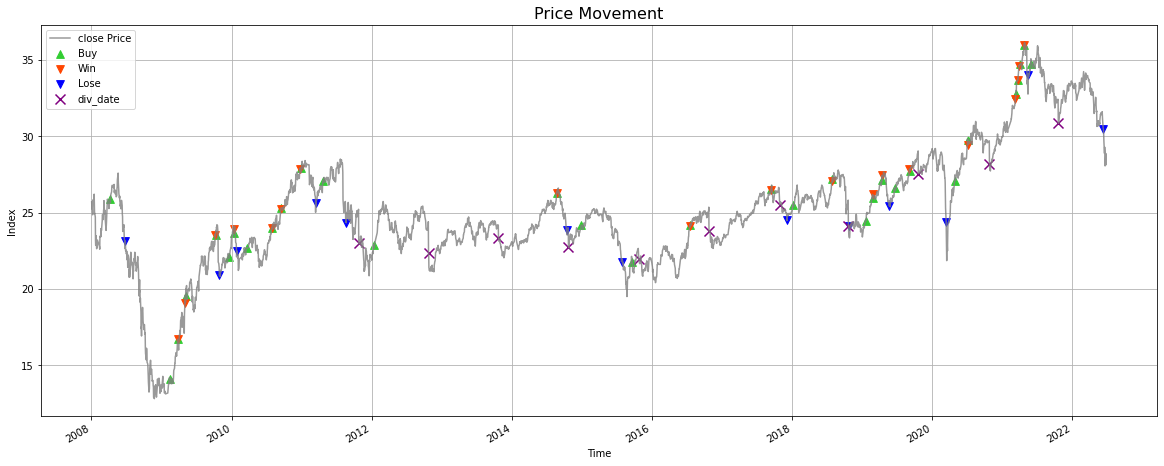

In [168]:
# 實際交易位置
print('buy:{}'.format(df.iloc[buy].index))
print('win:{}'.format(df.iloc[sell_win].index))
print('lose:{}'.format(df.iloc[sell_lose].index))
print('--------------')
print('win ratio :{}'.format(len(sell_win)/len(buy)))

fig, ax = plt.subplots(figsize = (20,8))
df['close'].plot(label = 'close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'limegreen', label = 'Buy', marker='^', s=60)
plt.scatter(df['close'].iloc[sell_win].index, df['close'].iloc[sell_win],c = 'orangered', label = 'Win', marker='v', s=60)
plt.scatter(df['close'].iloc[sell_lose].index, df['close'].iloc[sell_lose],c = 'b', label = 'Lose', marker='v', s=60)
plt.scatter(df['close'].loc[List].index, df['close'].loc[List],c = 'purple', label = 'div_date', marker='x', s=100)

# plt.xlim('2010-01-01', '2022-01-01')
# plt.ylim(40, 145)

plt.legend()
plt.ylabel('Index')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

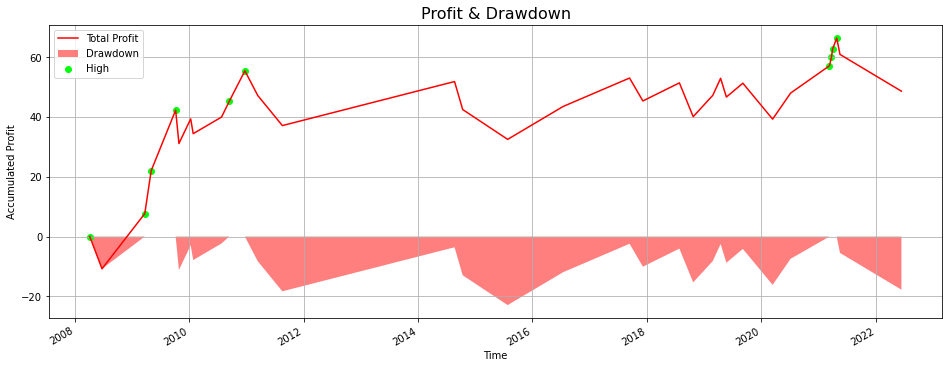

In [169]:
equity['equity'] = equity['profit'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profit'].cummax() == equity['profit']].index
equity['profit'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profit'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);


### for all

In [156]:
# 新策略
symbol = '0050.TW'
print(f'---loading: {symbol}---')
data = yf.Ticker(symbol)
df = data.history(period='D', start='2008-1-1', end='2022-6-30')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['EMA'] = abstract.EMA(df, timeperiod = 60)
df['MACD'] = abstract.MACD(df, fastperiod=11, slowperiod=40, signalperiod=9)['macd']
df['SAR'] = abstract.SAR(df)

fund = 100 #初始有100元本金
money = 100 #每次投入100元
feeRate = 0.003
length = 40 # 均線長度
stdTimes = 2 # 標準差倍數
rule = '1H' # hour


first = 0 ##除了第一筆之外，只紀錄出場的時間點
BS = None ##紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0

#--------# 記錄買入、賣出時間點
buy = []
sell = []
sellshort = []
buytocover = []
# stopLoss = []
#--------# 
timeList = [] 
profit_list = [0]
profit_fee_list = [0]


for i in range(len(df)):

    if first == 0:
        timeList.append(df.index[i+1])
        first = 1
        continue

    if i == len(df)-1: # last trading day
        break
     
      # buy                                       # BS: position, B: buy, S: sell
    if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
        temp = df['close'][i+1] # 要加一 當看到訊號後的進場價
        tempSize = money / temp # 計算交易單位
        BS = 'B' # 做多
        t = i+1 
        buy.append(t)
        stopLoss = df['SAR'][i] * 0.9
        stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
        # stopLoss.append(df['close'][i] - df['SAR'][i])

        
        

      # try 'buy' first 
      # sellshort
    # if df['close'][i] < df['EMA'][i] and df['MACD'][i] < 0 and df['close'][i] < df['SAR'][i] and BS == None:
    #     temp = df['close'][i+1]
    #     tempSize = money / temp
    #     BS = 'S'
    #     t = i+1
    #     sellshort.append(t)
        

    #     if first == 0:
    #         timeList.append(df.index[i+1])
    #         first = 1
    #     continue
        
      # buy停利
    if df['close'][i] > stopEarn and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

      # buy停損
    if df['close'][i] < stopLoss and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

       # buy to cover
    # if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
    #     profit = tempSize * (temp - df['close'][i+1])
    #     profit_fee = profit - money*feeRate - (money+profit)*feeRate
    #     profit_fee_list.append(profit_fee)
    #     profit_list.append(profit)
    #     buytocover.append(i+1)
    #     timeList.append(df.index[i])
    #     BS=None
    #     continue
    
    # 可加停利停損在這裡：if......
    
# equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=timeList)

equity = pd.DataFrame({'0050.TW':profit_list}, index=timeList)

########-------------------------------------------------------------#########

symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
               '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
               '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

for j in range(len(symbol_list)):
  symbol = symbol_list[j]

  print(f'---loading: {symbol}---')

    
  data = yf.Ticker(symbol)
  df = data.history(period='D', start='2008-1-1', end='2022-6-30')
  df = df.drop(columns = ['Dividends', 'Stock Splits'])
  df.columns = ['open', 'high', 'low', 'close', 'volume']
  df['EMA'] = abstract.EMA(df, timeperiod = 60)
  df['MACD'] = abstract.MACD(df, fastperiod=11, slowperiod=40, signalperiod=9)['macd']
  df['SAR'] = abstract.SAR(df)

  fund = 100 #初始有100元本金
  money = 100 #每次投入100元
  feeRate = 0.003
  length = 40 # 均線長度
  stdTimes = 2 # 標準差倍數
  rule = '1H' # hour


  first = 0 ##除了第一筆之外，只紀錄出場的時間點
  BS = None ##紀錄現在的狀態是做多還做空
  stopEarn = 0
  stopLoss = 0

  #--------# 記錄買入、賣出時間點
  buy = []
  sell = []
  sellshort = []
  buytocover = []
  # stopLoss = []
  #--------# 
  timeList = [] 
  profit_list = [0]
  profit_fee_list = [0]


  for i in range(len(df)):

      if first == 0:
          timeList.append(df.index[i+1])
          first = 1
          continue

      if i == len(df)-1: # last trading day
          break
      
        # buy                                       # BS: position, B: buy, S: sell
      if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
          temp = df['close'][i+1] # 要加一 當看到訊號後的進場價
          tempSize = money / temp # 計算交易單位
          BS = 'B' # 做多
          t = i+1 
          buy.append(t)
          stopLoss = df['SAR'][i]
          stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
          # stopLoss.append(df['close'][i] - df['SAR'][i])

          
      

        # try 'buy' first 
        # sellshort
      # if df['close'][i] < df['EMA'][i] and df['MACD'][i] < 0 and df['close'][i] < df['SAR'][i] and BS == None:
      #     temp = df['close'][i+1]
      #     tempSize = money / temp
      #     BS = 'S'
      #     t = i+1
      #     sellshort.append(t)
          

      #     if first == 0:
      #         timeList.append(df.index[i+1])
      #         first = 1
      #     continue
          
        # buy停利
      if df['close'][i] > stopEarn and BS == 'B':
          profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue

        # buy停損
      if df['close'][i] < stopLoss and BS == 'B':
          profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue

        # buy to cover
      # if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
      #     profit = tempSize * (temp - df['close'][i+1])
      #     profit_fee = profit - money*feeRate - (money+profit)*feeRate
      #     profit_fee_list.append(profit_fee)
      #     profit_list.append(profit)
      #     buytocover.append(i+1)
      #     timeList.append(df.index[i])
      #     BS=None
      #     continue
      
      # 可加停利停損在這裡：if......
      
  # equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=timeList)

  pp = pd.DataFrame({'{}'.format(symbol_list[j]):profit_list}, index=timeList)
  equity = pd.concat([equity,pp], join='outer', axis=1)

---loading: 0050.TW---
---loading: 0051.TW---
---loading: 0052.TW---
---loading: 0053.TW---
---loading: 0055.TW---
---loading: 0056.TW---
---loading: 006203.TW---
---loading: 006204.TW---
---loading: 006208.TW---
---loading: 00690.TW---
---loading: 00692.TW---
---loading: 00701.TW---
---loading: 00712.TW---
---loading: 00713.TW---
---loading: 00714.TW---
---loading: 00717.TW---
---loading: 00728.TW---
---loading: 00730.TW---
---loading: 00731.TW---
---loading: 00733.TW---
---loading: 00735.TW---


In [157]:
equity = equity.fillna(0)
df_ATC = equity.sum(axis = 0)
print(df_ATC, f'mean : {df_ATC.mean()}')

0050.TW      134.060098
0051.TW      101.734029
0052.TW      158.060712
0053.TW      129.768321
0055.TW       71.996548
0056.TW       63.303283
006203.TW     56.410239
006204.TW     90.477536
006208.TW     72.024458
00690.TW      32.705928
00692.TW      35.849729
00701.TW      26.464368
00712.TW      -0.076002
00713.TW      35.196316
00714.TW      24.377332
00717.TW      -6.014462
00728.TW      24.679074
00730.TW       6.425836
00731.TW      32.608791
00733.TW      98.847724
00735.TW      46.321201
dtype: float64 mean : 58.820050378875216


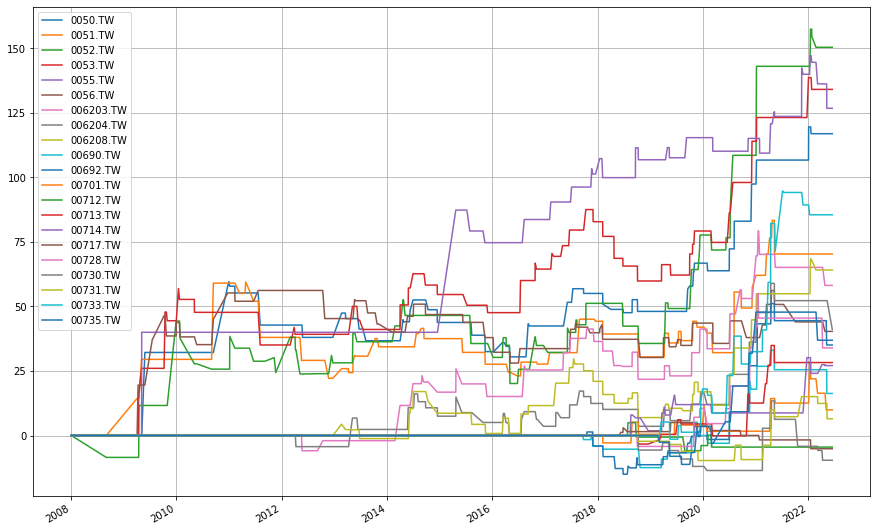

In [ ]:
np.cumsum(equity).plot(grid=True, figsize=(15, 10))

## **Add div_date**

*   若於除息期間仍持有，則除息前賣出，除完息再重新進場




### for single model

In [199]:
startday = '2008-1-1'
endday = '2022-1-1'

symbol = '0056.TW'
print(f'---loading: {symbol}---')
data = yf.Ticker(symbol)
df = data.history(period='D', start = startday, end = endday)
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']

df['EMA'] = abstract.EMA(df, timeperiod = 200)
df['MACD'] = abstract.MACD(df, fastperiod=9, slowperiod=24, signalperiod=9)['macd']
df['SAR'] = abstract.SAR(df)

Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['Date']))
Yield = Yield.drop('Date', axis = 1)

df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)
sum(df['close'].isnull())

---loading: 0056.TW---


0

In [208]:
startday = '2008-1-1'
endday = '2022-1-1'

symbol = '0056.TW'
print(f'---loading: {symbol}---')
data = yf.Ticker(symbol)
df = data.history(period='D', start = startday, end = endday)
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']

df['EMA'] = abstract.EMA(df, timeperiod = 200)
df['MACD'] = abstract.MACD(df, fastperiod=9, slowperiod=24, signalperiod=9)['macd']
df['SAR'] = abstract.SAR(df)

Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['Date']))
Yield = Yield.drop('Date', axis = 1)
df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)

fund = 100 #初始有100元本金
money = 100 #每次投入100元

first = 0 ##除了第一筆之外，只紀錄出場的時間點
BS = None ##紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0
feeRate = 0.3

#--------# 記錄買入、賣出時間點
buy = []
sell_win = []
sell_lose = []
buy_yld = []
sell_yld = []
#--------# 
timeList = [] 
profit_list = [0]


for i in range(len(df)):

    if first == 0:
        timeList.append(df.index[i+1])
        first = 1
        continue

    if i == len(df)-1: # last trading day
        break
     
      # buy                                       # BS: position, B: buy, S: sell
    if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
        temp = df['close'][i+1] # 要加一 當看到訊號後的進場價
        tempSize = money / temp # 計算交易單位
        BS = 'B' # 做多
        buy.append(i+1)
        stopLoss = df['SAR'][i] * 0.95
        stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
        # stopLoss.append(df['close'][i] - df['SAR'][i])
        continue
        
      # 除息前處理
    if df[symbol][i] > 0 and BS == 'B':
        profit = tempSize * (df['close'][i-2] - temp) # 在除息前兩天出場
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_yld.append(i-2)
        timeList.append(df.index[i-2])

        temp = df['close'][i+1] # 除完息買進
        tempSize = money / temp 
        buy_yld.append(i+1)
        continue
    
        
      # buy停利
    if df['close'][i] > stopEarn and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_win.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

      # buy停損
    if df['close'][i] < stopLoss and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_lose.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue
    
    
# equity = pd.DataFrame({'profit':profit_list}, index=timeList)
equity = pd.DataFrame({'profit':np.cumsum(profit_list)}, index=timeList)
equity

---loading: 0056.TW---


,profit
2008-01-03,0.000000
2009-05-11,8.035717
2009-09-07,23.750002
2010-10-06,38.251113
2010-12-01,45.047230
2011-08-19,33.713409
2012-10-22,31.222594
2012-10-26,26.544235
2013-05-16,30.351349
2013-06-25,23.841990


buy:DatetimeIndex(['2009-04-10', '2009-05-13', '2009-09-09', '2010-10-08',
               '2010-12-03', '2012-02-03', '2013-01-30', '2013-05-20',
               '2013-07-11', '2014-06-03', '2014-08-26', '2015-01-14',
               '2016-02-19', '2016-07-15', '2017-07-21', '2018-01-04',
               '2018-01-30', '2019-02-13', '2019-04-03', '2019-09-10',
               '2020-04-30', '2020-07-24', '2020-11-25', '2021-02-25',
               '2021-04-20', '2021-11-18'],
              dtype='datetime64[ns]', name='Date', freq=None)
win:DatetimeIndex(['2009-05-12', '2009-09-08', '2010-10-07', '2010-12-02',
               '2013-05-17', '2014-05-30', '2014-08-25', '2016-07-14',
               '2017-07-20', '2018-01-29', '2019-04-02', '2019-09-06',
               '2020-07-23', '2021-02-24', '2021-04-19'],
              dtype='datetime64[ns]', name='Date', freq=None)
lose:DatetimeIndex(['2011-08-22', '2012-10-29', '2013-06-26', '2014-10-14',
               '2015-07-27', '2017-12-08', '2018-10

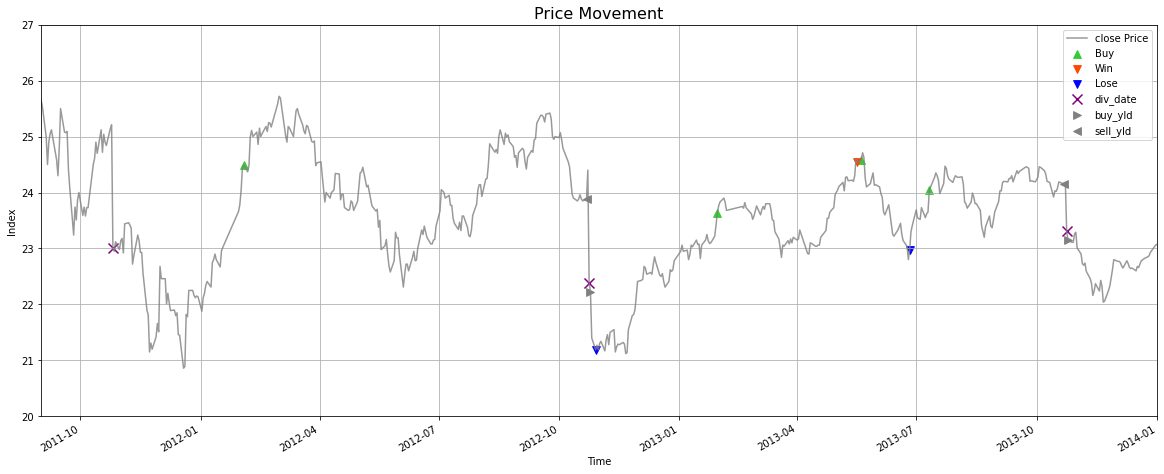

In [213]:
# 實際交易位置
print('buy:{}'.format(df.iloc[buy].index))
print('win:{}'.format(df.iloc[sell_win].index))
print('lose:{}'.format(df.iloc[sell_lose].index))
print('buy_yld:{}'.format(df.iloc[buy_yld].index))
print('sell_yld:{}'.format(df.iloc[sell_yld].index))
print('--------------')
print('win ratio :{}'.format(len(sell_win)/len(buy)))

fig, ax = plt.subplots(figsize = (20,8))
df['close'].plot(label = 'close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'limegreen', label = 'Buy', marker='^', s=60)
plt.scatter(df['close'].iloc[sell_win].index, df['close'].iloc[sell_win],c = 'orangered', label = 'Win', marker='v', s=60)
plt.scatter(df['close'].iloc[sell_lose].index, df['close'].iloc[sell_lose],c = 'b', label = 'Lose', marker='v', s=60)
plt.scatter(df['close'].loc[List].index, df['close'].loc[List],c = 'purple', label = 'div_date', marker='x', s=100)
plt.scatter(df['close'].iloc[buy_yld].index, df['close'].iloc[buy_yld],c = 'grey', label = 'buy_yld', marker='>', s=60)
plt.scatter(df['close'].iloc[sell_yld].index, df['close'].iloc[sell_yld],c = 'grey', label = 'sell_yld', marker='<', s=60)

plt.xlim('2011-09-01', '2014-01-01')
plt.ylim(20, 27)

plt.legend()
plt.ylabel('Index')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

# **Optimization**

## EMA
* result : fast = 17, slow = 38

In [ ]:
# 新策略
opt_list = []


for time in range(30, 101, 10):

  symbol = '0050.TW'
  data = yf.Ticker(symbol)
  df = data.history(period='D', start='2008-1-1', end='2022-1-1')
  df = df.drop(columns = ['Dividends', 'Stock Splits'])
  df.columns = ['open', 'high', 'low', 'close', 'volume']
  fund = 100 #初始有100元本金
  money = 100 #每次投入100元
  feeRate = 0.003
  length = 40 # 均線長度
  stdTimes = 2 # 標準差倍數


  first = 0 ##除了第一筆之外，只紀錄出場的時間點
  BS = None ##紀錄現在的狀態是做多還做空
  stopEarn = 0
  stopLoss = 0

  print('#####----------#####')
  print(f'period: {time}')

  print(f'---loading: {symbol}---')

  df['EMA'] = abstract.EMA(df, timeperiod = time)
  df['MACD'] = abstract.MACD(df, fastperiod=17, slowperiod=38, signalperiod=9)['macd']
  df['SAR'] = abstract.SAR(df)

  #--------# 記錄買入、賣出時間點
  buy = []
  sell = []
  sellshort = []
  buytocover = []
  # stopLoss = []
  #--------# 
  timeList = [] 
  profit_list = [0]
  profit_fee_list = [0]


  for i in range(len(df)):

      if first == 0:
          timeList.append(df.index[i+1])
          first = 1
          continue

      if i == len(df)-1: # last trading day
          break
      
        # buy                                       # BS: position, B: buy, S: sell
      if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
          temp = df['close'][i+1] # 要加一 當看到訊號後的進場價
          tempSize = money / temp # 計算交易單位
          BS = 'B' # 做多
          t = i+1 
          buy.append(t)
          stopLoss = df['SAR'][i]
          stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
          # stopLoss.append(df['close'][i] - df['SAR'][i])


        # try 'buy' first 
        # sellshort
      # if df['close'][i] < df['EMA'][i] and df['MACD'][i] < 0 and df['close'][i] < df['SAR'][i] and BS == None:
      #     temp = df['open'][i+1]
      #     tempSize = money / temp
      #     BS = 'S'
      #     t = i+1
      #     sellshort.append(t)
          

      #     if first == 0:
      #         timeList.append(df.index[i+1])
      #         first = 1
      #     continue
          
        # buy停利
      if df['close'][i] > stopEarn and BS == 'B':
          profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue

        # buy停損
      if df['close'][i] < stopLoss and BS == 'B':
          profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue

        # buy to cover
      # if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
      #     profit = tempSize * (temp - df['open'][i+1])
      #     profit_fee = profit - money*feeRate - (money+profit)*feeRate
      #     profit_fee_list.append(profit_fee)
      #     profit_list.append(profit)
      #     buytocover.append(i+1)
      #     timeList.append(df.index[i])
      #     BS=None
      #     continue
      
      # 可加停利停損在這裡：if......
      
  # equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=timeList)

  equity = pd.DataFrame({'0050.TW':profit_list}, index=timeList)

  ########-------------------------------------------------------------#########

  symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
                '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
                '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

  for j in range(len(symbol_list)):
    symbol = symbol_list[j]

    print(f'---loading: {symbol}---')

      
    data = yf.Ticker(symbol)
    df = data.history(period='D', start='2008-1-1', end='2022-1-1')
    df = df.drop(columns = ['Dividends', 'Stock Splits'])
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    df['EMA'] = abstract.EMA(df, timeperiod = time)
    df['MACD'] = abstract.MACD(df, fastperiod=17, slowperiod=38, signalperiod=9)['macd']
    df['SAR'] = abstract.SAR(df)

    fund = 100 #初始有100元本金
    money = 100 #每次投入100元
    feeRate = 0.003
    length = 40 # 均線長度
    stdTimes = 2 # 標準差倍數
    rule = '1H' # hour


    first = 0 ##除了第一筆之外，只紀錄出場的時間點
    BS = None ##紀錄現在的狀態是做多還做空
    stopEarn = 0
    stopLoss = 0

    #--------# 記錄買入、賣出時間點
    buy = []
    sell = []
    sellshort = []
    buytocover = []
    # stopLoss = []
    #--------# 
    timeList = [] 
    profit_list = [0]
    profit_fee_list = [0]


    for i in range(len(df)):

        if first == 0:
            timeList.append(df.index[i+1])
            first = 1
            continue

        if i == len(df)-1: # last trading day
            break
        
          # buy                                       # BS: position, B: buy, S: sell
        if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
            temp = df['close'][i+1] # 要加一 當看到訊號後的進場價
            tempSize = money / temp # 計算交易單位
            BS = 'B' # 做多
            t = i+1 
            buy.append(t)
            stopLoss = df['SAR'][i]
            stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
            # stopLoss.append(df['close'][i] - df['SAR'][i])   

          # try 'buy' first 
          # sellshort
        # if df['close'][i] < df['EMA'][i] and df['MACD'][i] < 0 and df['close'][i] < df['SAR'][i] and BS == None:
        #     temp = df['open'][i+1]
        #     tempSize = money / temp
        #     BS = 'S'
        #     t = i+1
        #     sellshort.append(t)
            

        #     if first == 0:
        #         timeList.append(df.index[i+1])
        #         first = 1
        #     continue
            
          # buy停利
        if df['close'][i] > stopEarn and BS == 'B':
            profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
            profit_fee = profit - money*feeRate - (money+profit)*feeRate
            profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            sell.append(i+1)
            timeList.append(df.index[i])
            BS=None
            continue

          # buy停損
        if df['close'][i] < stopLoss and BS == 'B':
            profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
            profit_fee = profit - money*feeRate - (money+profit)*feeRate
            profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            sell.append(i+1)
            timeList.append(df.index[i])
            BS=None
            continue

          # buy to cover
        # if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
        #     profit = tempSize * (temp - df['open'][i+1])
        #     profit_fee = profit - money*feeRate - (money+profit)*feeRate
        #     profit_fee_list.append(profit_fee)
        #     profit_list.append(profit)
        #     buytocover.append(i+1)
        #     timeList.append(df.index[i])
        #     BS=None
        #     continue
        
        # 可加停利停損在這裡：if......
        
    # equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=timeList)

    pp = pd.DataFrame({'{}'.format(symbol_list[j]):profit_list}, index=timeList)
    equity = pd.concat([equity,pp], join='outer', axis=1)

  equity.fillna(0)
  df_ATC = equity.sum(axis = 0)
  ret = df_ATC.mean()
  opt_list.append([time, ret])


#####----------#####
period: 30
---loading: 0050.TW---
---loading: 0051.TW---
---loading: 0052.TW---
---loading: 0053.TW---
---loading: 0055.TW---
---loading: 0056.TW---
---loading: 006203.TW---
---loading: 006204.TW---
---loading: 006208.TW---
---loading: 00690.TW---
---loading: 00692.TW---
---loading: 00701.TW---
---loading: 00712.TW---
---loading: 00713.TW---
---loading: 00714.TW---
---loading: 00717.TW---
---loading: 00728.TW---
---loading: 00730.TW---
---loading: 00731.TW---
---loading: 00733.TW---
---loading: 00735.TW---
#####----------#####
period: 40
---loading: 0050.TW---
---loading: 0051.TW---
---loading: 0052.TW---
---loading: 0053.TW---
---loading: 0055.TW---
---loading: 0056.TW---
---loading: 006203.TW---
---loading: 006204.TW---
---loading: 006208.TW---
---loading: 00690.TW---
---loading: 00692.TW---
---loading: 00701.TW---
---loading: 00712.TW---
---loading: 00713.TW---
---loading: 00714.TW---
---loading: 00717.TW---
---loading: 00728.TW---
---loading: 00730.TW---
---loa

In [ ]:
optResult = pd.DataFrame(opt_list, columns=['period','return'])
optResult.sort_values('return', ascending = False)

## MACD
* result : fast = 17, slow = 38

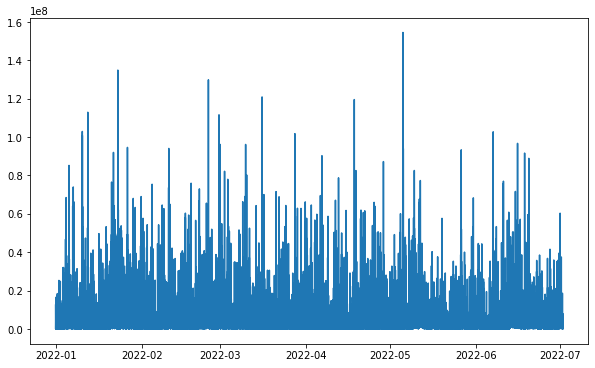

In [ ]:
# 新策略
opt_list = []


for fast in range(5, 20, 2):
  for slow in range(20, 41, 2):

    symbol = '0050.TW'
    data = yf.Ticker(symbol)
    df = data.history(period='D', start='2008-1-1', end='2022-1-1')
    df = df.drop(columns = ['Dividends', 'Stock Splits'])
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    fund = 100 #初始有100元本金
    money = 100 #每次投入100元
    feeRate = 0.003
    length = 40 # 均線長度
    stdTimes = 2 # 標準差倍數
    rule = '1H' # hour


    first = 0 ##除了第一筆之外，只紀錄出場的時間點
    BS = None ##紀錄現在的狀態是做多還做空
    stopEarn = 0
    stopLoss = 0

    print('#####----------#####')
    print(f'fast: {fast}')
    print(f'slow: {slow}')

    print(f'---loading: {symbol}---')

    df['EMA'] = abstract.EMA(df, timeperiod = 200)
    df['MACD'] = abstract.MACD(df, fastperiod=fast, slowperiod=slow, signalperiod=9)['macd']
    df['SAR'] = abstract.SAR(df)

    #--------# 記錄買入、賣出時間點
    buy = []
    sell = []
    sellshort = []
    buytocover = []
    # stopLoss = []
    #--------# 
    timeList = [] 
    profit_list = [0]
    profit_fee_list = [0]


    for i in range(len(df)):

        if i == len(df)-1: # last trading day
            break
        
          # buy                                       # BS: position, B: buy, S: sell
        if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
            temp = df['open'][i+1] # 要加一 當看到訊號後的進場價
            tempSize = money / temp # 計算交易單位
            BS = 'B' # 做多
            t = i+1 
            buy.append(t)
            stopLoss = df['SAR'][i]
            stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
            # stopLoss.append(df['close'][i] - df['SAR'][i])

            
            if first == 0:
                timeList.append(df.index[i+1])
                first = 1
            continue

          # try 'buy' first 
          # sellshort
        # if df['close'][i] < df['EMA'][i] and df['MACD'][i] < 0 and df['close'][i] < df['SAR'][i] and BS == None:
        #     temp = df['open'][i+1]
        #     tempSize = money / temp
        #     BS = 'S'
        #     t = i+1
        #     sellshort.append(t)
            

        #     if first == 0:
        #         timeList.append(df.index[i+1])
        #         first = 1
        #     continue
            
          # buy停利
        if df['close'][i] > stopEarn and BS == 'B':
            profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
            profit_fee = profit - money*feeRate - (money+profit)*feeRate
            profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            sell.append(i+1)
            timeList.append(df.index[i])
            BS=None
            continue

          # buy停損
        if df['close'][i] < stopLoss and BS == 'B':
            profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
            profit_fee = profit - money*feeRate - (money+profit)*feeRate
            profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            sell.append(i+1)
            timeList.append(df.index[i])
            BS=None
            continue

          # buy to cover
        # if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
        #     profit = tempSize * (temp - df['open'][i+1])
        #     profit_fee = profit - money*feeRate - (money+profit)*feeRate
        #     profit_fee_list.append(profit_fee)
        #     profit_list.append(profit)
        #     buytocover.append(i+1)
        #     timeList.append(df.index[i])
        #     BS=None
        #     continue
        
        # 可加停利停損在這裡：if......
        
    # equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=timeList)

    equity = pd.DataFrame({'0050.TW':profit_list}, index=timeList)

    ########-------------------------------------------------------------#########

    symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
                  '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
                  '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

    for j in range(len(symbol_list)):
      symbol = symbol_list[j]

      print(f'---loading: {symbol}---')

        
      data = yf.Ticker(symbol)
      df = data.history(period='D', start='2008-1-1', end='2022-6-30')
      df = df.drop(columns = ['Dividends', 'Stock Splits'])
      df.columns = ['open', 'high', 'low', 'close', 'volume']
      df['EMA'] = abstract.EMA(df, timeperiod = 200)
      df['MACD'] = abstract.MACD(df, fastperiod=fast, slowperiod=slow, signalperiod=9)['macd']
      df['SAR'] = abstract.SAR(df)

      fund = 100 #初始有100元本金
      money = 100 #每次投入100元
      feeRate = 0.003
      length = 40 # 均線長度
      stdTimes = 2 # 標準差倍數
      rule = '1H' # hour


      first = 0 ##除了第一筆之外，只紀錄出場的時間點
      BS = None ##紀錄現在的狀態是做多還做空
      stopEarn = 0
      stopLoss = 0

      #--------# 記錄買入、賣出時間點
      buy = []
      sell = []
      sellshort = []
      buytocover = []
      # stopLoss = []
      #--------# 
      timeList = [] 
      profit_list = [0]
      profit_fee_list = [0]


      for i in range(len(df)):

          if i == len(df)-1: # last trading day
              break
          
            # buy                                       # BS: position, B: buy, S: sell
          if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
              temp = df['open'][i+1] # 要加一 當看到訊號後的進場價
              tempSize = money / temp # 計算交易單位
              BS = 'B' # 做多
              t = i+1 
              buy.append(t)
              stopLoss = df['SAR'][i]
              stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
              # stopLoss.append(df['close'][i] - df['SAR'][i])

              
              if first == 0:
                  timeList.append(df.index[i+1])
                  first = 1
              continue

            # try 'buy' first 
            # sellshort
          # if df['close'][i] < df['EMA'][i] and df['MACD'][i] < 0 and df['close'][i] < df['SAR'][i] and BS == None:
          #     temp = df['open'][i+1]
          #     tempSize = money / temp
          #     BS = 'S'
          #     t = i+1
          #     sellshort.append(t)
              

          #     if first == 0:
          #         timeList.append(df.index[i+1])
          #         first = 1
          #     continue
              
            # buy停利
          if df['close'][i] > stopEarn and BS == 'B':
              profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
              profit_fee = profit - money*feeRate - (money+profit)*feeRate
              profit_fee_list.append(profit_fee)
              profit_list.append(profit)
              sell.append(i+1)
              timeList.append(df.index[i])
              BS=None
              continue

            # buy停損
          if df['close'][i] < stopLoss and BS == 'B':
              profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
              profit_fee = profit - money*feeRate - (money+profit)*feeRate
              profit_fee_list.append(profit_fee)
              profit_list.append(profit)
              sell.append(i+1)
              timeList.append(df.index[i])
              BS=None
              continue

            # buy to cover
          # if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
          #     profit = tempSize * (temp - df['open'][i+1])
          #     profit_fee = profit - money*feeRate - (money+profit)*feeRate
          #     profit_fee_list.append(profit_fee)
          #     profit_list.append(profit)
          #     buytocover.append(i+1)
          #     timeList.append(df.index[i])
          #     BS=None
          #     continue
          
          # 可加停利停損在這裡：if......
          
      # equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=timeList)

      pp = pd.DataFrame({'{}'.format(symbol_list[j]):profit_list}, index=timeList)
      equity = pd.concat([equity,pp], join='outer', axis=1)

    equity.fillna(0)
    df_ATC = equity.sum(axis = 0)
    ret = df_ATC.mean()
    opt_list.append([fast, slow, ret])


Text(0, 0.5, 'volume')

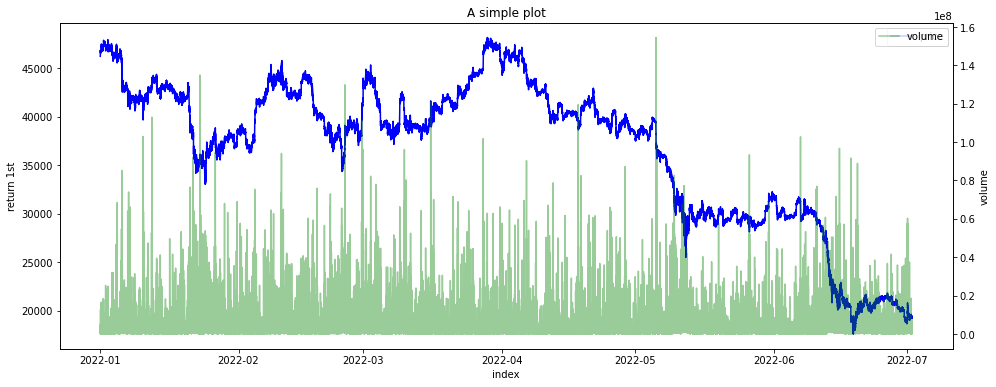

In [ ]:
optResult = pd.DataFrame(opt_list, columns=['fast','slow','return'])
optResult.sort_values('return', ascending = False)

In [ ]:
pic = optResult.pivot('fast', 'slow', 'return') # 先整理資料格式
sns.heatmap(data = pic).set(title='Return');

## All

In [ ]:
# 新策略
opt_list = []


for time in range(50, 251, 10):

  for fast in range(5, 20, 2):
    for slow in range(20, 41, 2):

      symbol = '0050.TW'
      data = yf.Ticker(symbol)
      df = data.history(period='D', start='2008-1-1', end='2022-1-1')
      df = df.drop(columns = ['Dividends', 'Stock Splits'])
      df.columns = ['open', 'high', 'low', 'close', 'volume']
      fund = 100 #初始有100元本金
      money = 100 #每次投入100元
      feeRate = 0.003

      first = 0 ##除了第一筆之外，只紀錄出場的時間點
      BS = None ##紀錄現在的狀態是做多還做空
      stopEarn = 0
      stopLoss = 0

      print('#####----------#####')
      print(f'period: {time}')
      print(f'fast: {fast}')
      print(f'slow: {slow}')

      print(f'---loading: {symbol}---')

      df['EMA'] = abstract.EMA(df, timeperiod = time)
      df['MACD'] = abstract.MACD(df, fastperiod=fast, slowperiod=slow, signalperiod=9)['macd']
      df['SAR'] = abstract.SAR(df)

      #--------# 記錄買入、賣出時間點
      buy = []
      sell = []
      sellshort = []
      buytocover = []
      # stopLoss = []
      #--------# 
      timeList = [] 
      profit_list = [0]
      profit_fee_list = [0]


      for i in range(len(df)):

          if first == 0:
              timeList.append(df.index[i+1])
              first = 1
              continue

          if i == len(df)-1: # last trading day
              break
          
            # buy                                       # BS: position, B: buy, S: sell
          if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
              temp = df['close'][i+1] # 要加一 當看到訊號後的進場價
              tempSize = money / temp # 計算交易單位
              BS = 'B' # 做多
              t = i+1 
              buy.append(t)
              stopLoss = df['SAR'][i]
              stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
              # stopLoss.append(df['close'][i] - df['SAR'][i])


              
            # buy停利
          if df['close'][i] > stopEarn and BS == 'B':
              profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
              profit_fee = profit - money*feeRate - (money+profit)*feeRate
              profit_fee_list.append(profit_fee)
              profit_list.append(profit)
              sell.append(i+1)
              timeList.append(df.index[i])
              BS=None
              continue

            # buy停損
          if df['close'][i] < stopLoss and BS == 'B':
              profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
              profit_fee = profit - money*feeRate - (money+profit)*feeRate
              profit_fee_list.append(profit_fee)
              profit_list.append(profit)
              sell.append(i+1)
              timeList.append(df.index[i])
              BS=None
              continue
    
      equity = pd.DataFrame({'0050.TW':profit_list}, index=timeList)

      ########-------------------------------------------------------------#########

      symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
                    '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
                    '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

      for j in range(len(symbol_list)):
        symbol = symbol_list[j]

        print(f'---loading: {symbol}---')

          
        data = yf.Ticker(symbol)
        df = data.history(period='D', start='2008-1-1', end='2022-1-1')
        df = df.drop(columns = ['Dividends', 'Stock Splits'])
        df.columns = ['open', 'high', 'low', 'close', 'volume']
        df['EMA'] = abstract.EMA(df, timeperiod = time)
        df['MACD'] = abstract.MACD(df, fastperiod=fast, slowperiod=slow, signalperiod=9)['macd']
        df['SAR'] = abstract.SAR(df)

        fund = 100 #初始有100元本金
        money = 100 #每次投入100元
        feeRate = 0.003
 
        first = 0 ##除了第一筆之外，只紀錄出場的時間點
        BS = None ##紀錄現在的狀態是做多還做空
        stopEarn = 0
        stopLoss = 0

        #--------# 記錄買入、賣出時間點
        buy = []
        sell = []
        sellshort = []
        buytocover = []
        # stopLoss = []
        #--------# 
        timeList = [] 
        profit_list = [0]
        profit_fee_list = [0]


        for i in range(len(df)):

            if first == 0:
                timeList.append(df.index[i+1])
                first = 1
                continue

            if i == len(df)-1: # last trading day
                break
            
              # buy                                       # BS: position, B: buy, S: sell
            if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
                temp = df['close'][i+1] # 要加一 當看到訊號後的進場價
                tempSize = money / temp # 計算交易單位
                BS = 'B' # 做多
                t = i+1 
                buy.append(t)
                stopLoss = df['SAR'][i]
                stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)            
                
              # buy停利
            if df['close'][i] > stopEarn and BS == 'B':
                profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
                profit_fee = profit - money*feeRate - (money+profit)*feeRate
                profit_fee_list.append(profit_fee)
                profit_list.append(profit)
                sell.append(i+1)
                timeList.append(df.index[i])
                BS=None
                continue

              # buy停損
            if df['close'][i] < stopLoss and BS == 'B':
                profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
                profit_fee = profit - money*feeRate - (money+profit)*feeRate
                profit_fee_list.append(profit_fee)
                profit_list.append(profit)
                sell.append(i+1)
                timeList.append(df.index[i])
                BS=None
                continue
          
        pp = pd.DataFrame({'{}'.format(symbol_list[j]):profit_list}, index=timeList)
        equity = pd.concat([equity,pp], join='outer', axis=1)

      equity.fillna(0)
      df_ATC = equity.sum(axis = 0)
      ret = df_ATC.mean()
      opt_list.append([time, fast, slow, ret])


串流輸出內容已截斷至最後 5000 行。
---loading: 00713.TW---
---loading: 00714.TW---
---loading: 00717.TW---
---loading: 00728.TW---
---loading: 00730.TW---
---loading: 00731.TW---
---loading: 00733.TW---
---loading: 00735.TW---
#####----------#####
period: 120
fast: 15
slow: 30
---loading: 0050.TW---
---loading: 0051.TW---
---loading: 0052.TW---
---loading: 0053.TW---
---loading: 0055.TW---
---loading: 0056.TW---
---loading: 006203.TW---
---loading: 006204.TW---
---loading: 006208.TW---
---loading: 00690.TW---
---loading: 00692.TW---
---loading: 00701.TW---
---loading: 00712.TW---
---loading: 00713.TW---
---loading: 00714.TW---
---loading: 00717.TW---
---loading: 00728.TW---
---loading: 00730.TW---
---loading: 00731.TW---
---loading: 00733.TW---
---loading: 00735.TW---
#####----------#####
period: 120
fast: 15
slow: 32
---loading: 0050.TW---
---loading: 0051.TW---
---loading: 0052.TW---
---loading: 0053.TW---
---loading: 0055.TW---
---loading: 0056.TW---
---loading: 006203.TW---
---loading: 006204.TW

KeyError: ignored

In [ ]:
optResult = pd.DataFrame(opt_list, columns=['period','fast', 'slow', 'return'])
optResult.sort_values('return', ascending = False)

,period,fast,slow,return
131,60,11,40,75.663821
209,70,11,20,74.677908
284,80,7,38,73.995777
472,100,9,40,73.648262
232,70,15,22,73.569004
...,...,...,...,...
855,140,15,36,49.354978
867,140,17,38,49.236695
769,130,15,40,49.012707
856,140,15,38,48.846779


# Optimal Solution
EMA = 60
MACD : fast = 11, slow = 40

In [ ]:

symbol = '0050.TW'
print(f'---loading: {symbol}---')
data = yf.Ticker(symbol)
df = data.history(period='D', start='2018-6-30', end='2022-6-30')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['EMA'] = abstract.EMA(df, timeperiod = 60)
df['MACD'] = abstract.MACD(df, fastperiod=11, slowperiod=40, signalperiod=9)['macd']
df['SAR'] = abstract.SAR(df)

fund = 100 #初始有100元本金
money = 100 #每次投入100元
feeRate = 0.003


first = 0 ##除了第一筆之外，只紀錄出場的時間點
BS = None ##紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0

#--------# 記錄買入、賣出時間點
buy = []
sell = []
sellshort = []
buytocover = []
# stopLoss = []
#--------# 
timeList = [] 
profit_list = [0]
profit_fee_list = [0]


for i in range(len(df)):

    if first == 0:
        timeList.append(df.index[i+1])
        first = 1
        continue

    if i == len(df)-1: # last trading day
        break
     
      # buy                                       # BS: position, B: buy, S: sell
    if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
        temp = df['close'][i+1] # 要加一 當看到訊號後的進場價
        tempSize = money / temp # 計算交易單位
        BS = 'B' # 做多
        t = i+1 
        buy.append(t)
        stopLoss = df['SAR'][i]
        stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
     
        
      # buy停利
    if df['close'][i] > stopEarn and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

      # buy停損
    if df['close'][i] < stopLoss and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue


equity = pd.DataFrame({'0050.TW':profit_list}, index=timeList)

########-------------------------------------------------------------#########

symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
               '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
               '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

for j in range(len(symbol_list)):
  symbol = symbol_list[j]

  print(f'---loading: {symbol}---')

    
  data = yf.Ticker(symbol)
  df = data.history(period='D', start='2018-6-30', end='2022-6-30')
  df = df.drop(columns = ['Dividends', 'Stock Splits'])
  df.columns = ['open', 'high', 'low', 'close', 'volume']
  df['EMA'] = abstract.EMA(df, timeperiod = 60)
  df['MACD'] = abstract.MACD(df, fastperiod=11, slowperiod=40, signalperiod=9)['macd']
  df['SAR'] = abstract.SAR(df)

  fund = 100 #初始有100元本金
  money = 100 #每次投入100元
  feeRate = 0.003


  first = 0 ##除了第一筆之外，只紀錄出場的時間點
  BS = None ##紀錄現在的狀態是做多還做空
  stopEarn = 0
  stopLoss = 0

  #--------# 記錄買入、賣出時間點
  buy = []
  sell = []
  sellshort = []
  buytocover = []
  # stopLoss = []
  #--------# 
  timeList = [] 
  profit_list = [0]
  profit_fee_list = [0]


  for i in range(len(df)):

      if first == 0:
          timeList.append(df.index[i+1])
          first = 1
          continue

      if i == len(df)-1: # last trading day
          break
      
        # buy                                       # BS: position, B: buy, S: sell
      if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
          temp = df['close'][i+1] # 要加一 當看到訊號後的進場價
          tempSize = money / temp # 計算交易單位
          BS = 'B' # 做多
          t = i+1 
          buy.append(t)
          stopLoss = df['SAR'][i]
          stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
          # stopLoss.append(df['close'][i] - df['SAR'][i])

    
          
        # buy停利
      if df['close'][i] > stopEarn and BS == 'B':
          profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue

        # buy停損
      if df['close'][i] < stopLoss and BS == 'B':
          profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue

  pp = pd.DataFrame({'{}'.format(symbol_list[j]):profit_list}, index=timeList)
  equity = pd.concat([equity,pp], join='outer', axis=1)

---loading: 0050.TW---
---loading: 0051.TW---
---loading: 0052.TW---
---loading: 0053.TW---
---loading: 0055.TW---
---loading: 0056.TW---
---loading: 006203.TW---
---loading: 006204.TW---
---loading: 006208.TW---
---loading: 00690.TW---
---loading: 00692.TW---
---loading: 00701.TW---
---loading: 00712.TW---
---loading: 00713.TW---
---loading: 00714.TW---
---loading: 00717.TW---
---loading: 00728.TW---
---loading: 00730.TW---
---loading: 00731.TW---
---loading: 00733.TW---
---loading: 00735.TW---


In [ ]:
equity = equity.fillna(0)
df_ATC = equity.sum(axis = 0)
print(df_ATC, f'mean : {df_ATC.mean()}')

0050.TW       69.100941
0051.TW       40.210511
0052.TW      105.458160
0053.TW       76.308607
0055.TW       12.490523
0056.TW        6.569849
006203.TW     38.100946
006204.TW     41.554132
006208.TW     62.541003
00690.TW      27.381585
00692.TW      44.527998
00701.TW      13.855287
00712.TW      -2.262930
00713.TW      37.784900
00714.TW      14.261991
00717.TW      -8.023002
00728.TW      23.740105
00730.TW       4.744957
00731.TW      25.024373
00733.TW      95.860273
00735.TW      48.459279
dtype: float64 mean : 37.03283269255977


Annualized return : 8.195 %
Maximum drawdown : -7.157395038734677
Annualized volatility : 13.168636004748604 %
Sharpe Ratio: 0.6223119840995595


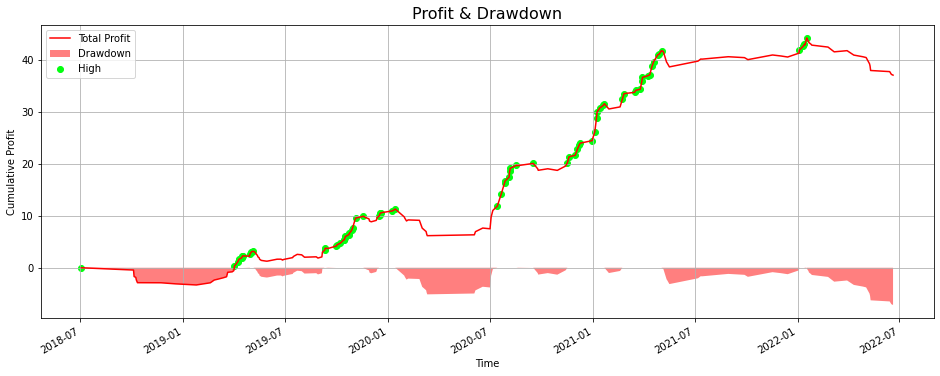

In [ ]:
ann_ret = round((((df_ATC.mean()+fund)/fund) ** (1/4) -1) * 100  , 3) 
equity['profit'] = np.cumsum(equity, axis = 0).mean(axis = 1)
equity['equity'] = equity['profit'] + fund
high_index = equity[equity['profit'].cummax() == equity['profit']].index
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

# 年化波動(不確定)
df = equity.mean(axis = 1)
risk = df.pct_change(1).dropna()[1:].std()
risk_Y = risk* m.sqrt(252/len(df)) * 100

# sharpe
sharpe_ratio = ann_ret/risk_Y

#----# 績效計算
# print('annualized return : {} %'.format(ann_ret))
print('Annualized return : {} %'.format(ann_ret))
print('Maximum drawdown : {}'.format(abs(min(equity['drawdown']))))
print('Annualized volatility : {} %'.format(risk_Y))
print('Sharpe Ratio: {}'.format(sharpe_ratio))

fig, ax = plt.subplots(figsize = (16,6))

equity['profit'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profit'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Cumulative Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);


# **End**